# 7. Take an image, apply Discrete Cosine transformation, quantize data and apply Huffman coding. Apply Huffman decoding and inverse Discrete Cosine Transform to obtain reconstructed image. Calculate Compression Ratio and PSNR. (use different quantization value and analyze reconstructed image quality.)7. Take an image, apply Discrete Cosine transformation, quantize data and apply Huffman coding. Apply Huffman decoding and inverse Discrete Cosine Transform to obtain reconstructed image. Calculate Compression Ratio and PSNR. (use different quantization value and analyze reconstructed image quality.)

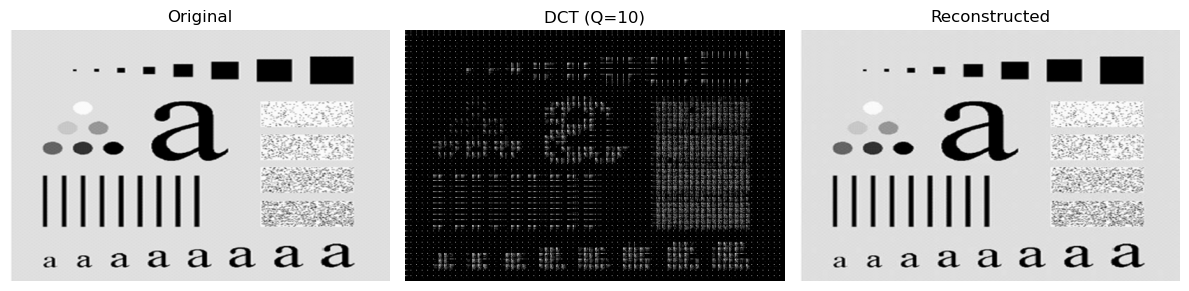

Quantization Factor: 10
Compression Ratio: 4.62
PSNR: 42.76 dB


In [2]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import heapq
from collections import Counter
import math


def dct_2d(block):
    N = 8
    result = np.zeros((N, N))
    for u in range(N):
        for v in range(N):
            sum_ = 0.0
            for x in range(N):
                for y in range(N):
                    sum_ += block[x, y] * \
                            np.cos(((2 * x + 1) * u * np.pi) / (2 * N)) * \
                            np.cos(((2 * y + 1) * v * np.pi) / (2 * N))
            c_u = 1 / np.sqrt(2) if u == 0 else 1
            c_v = 1 / np.sqrt(2) if v == 0 else 1
            result[u, v] = 0.25 * c_u * c_v * sum_
    return result

def idct_2d(block):
    N = 8
    result = np.zeros((N, N))
    for x in range(N):
        for y in range(N):
            sum_ = 0.0
            for u in range(N):
                for v in range(N):
                    c_u = 1 / np.sqrt(2) if u == 0 else 1
                    c_v = 1 / np.sqrt(2) if v == 0 else 1
                    sum_ += c_u * c_v * block[u, v] * \
                            np.cos(((2 * x + 1) * u * np.pi) / (2 * N)) * \
                            np.cos(((2 * y + 1) * v * np.pi) / (2 * N))
            result[x, y] = 0.25 * sum_
    return result


class Node:
    def __init__(self, symbol, freq):
        self.symbol = symbol
        self.freq = freq
        self.left = None
        self.right = None

    def __lt__(self, node):
        return self.freq < node.freq

def build_huffman_tree(freq):
    heap = [Node(symbol, f) for symbol, f in freq.items()]
    heapq.heapify(heap)

    while len(heap) > 1:
        n1 = heapq.heappop(heap)
        n2 = heapq.heappop(heap)
        merged = Node(None, n1.freq + n2.freq)
        merged.left, merged.right = n1, n2
        heapq.heappush(heap, merged)
    return heap[0]

def build_code_table(node, prefix='', codebook={}):
    if node:
        if node.symbol is not None:
            codebook[node.symbol] = prefix
        build_code_table(node.left, prefix + '0', codebook)
        build_code_table(node.right, prefix + '1', codebook)
    return codebook

def huffman_encode(data):
    freq = Counter(data)
    tree = build_huffman_tree(freq)
    codebook = build_code_table(tree)
    encoded = ''.join([codebook[val] for val in data])
    return encoded, tree, codebook

def huffman_decode(encoded, tree):
    decoded = []
    node = tree
    for bit in encoded:
        node = node.left if bit == '0' else node.right
        if node.symbol is not None:
            decoded.append(node.symbol)
            node = tree
    return decoded


def psnr(original, reconstructed):
    mse = np.mean((original - reconstructed) ** 2)
    if mse == 0: return float('inf')
    return 20 * np.log10(255.0 / np.sqrt(mse))


def load_and_preprocess_image(image_path):
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    h, w = img.shape
    img = img[:h - h % 8, :w - w % 8]
    img_shifted = img.astype(np.float32) - 128
    return img, img_shifted

def apply_dct_and_quantization(img_shifted, quant_factor):
    h, w = img_shifted.shape
    dct_image = np.zeros_like(img_shifted)
    for i in range(0, h, 8):
        for j in range(0, w, 8):
            block = img_shifted[i:i+8, j:j+8]
            dct_block = dct_2d(block)
            quantized = np.round(dct_block / quant_factor)
            dct_image[i:i+8, j:j+8] = quantized
    return dct_image

def compress_with_huffman(dct_image):
    flat_quantized = dct_image.flatten().astype(np.int32)
    encoded_data, tree, codebook = huffman_encode(flat_quantized.tolist())
    return encoded_data, tree, dct_image.shape

def decompress_with_huffman(encoded_data, tree, shape):
    decoded_flat = huffman_decode(encoded_data, tree)
    decoded_quantized = np.array(decoded_flat, dtype=np.float32).reshape(shape)
    return decoded_quantized

def reconstruct_image(decoded_quantized, quant_factor):
    h, w = decoded_quantized.shape
    reconstructed = np.zeros((h, w), dtype=np.float32)
    for i in range(0, h, 8):
        for j in range(0, w, 8):
            block = decoded_quantized[i:i+8, j:j+8] * quant_factor
            idct_block = idct_2d(block)
            reconstructed[i:i+8, j:j+8] = idct_block + 128
    return np.clip(reconstructed, 0, 255).astype(np.uint8)

def compute_metrics(original, reconstructed, encoded_data):
    original_bits = original.size * 8
    compressed_bits = len(encoded_data)
    compression_ratio = original_bits / compressed_bits
    psnr_value = psnr(original, reconstructed)
    return compression_ratio, psnr_value

def plot_results(original, dct_image, reconstructed, quant_factor):
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 3, 1)
    plt.title("Original")
    plt.imshow(original, cmap='gray')
    plt.axis('off')
    plt.subplot(1, 3, 2)
    plt.title(f"DCT (Q={quant_factor})")
    plt.imshow(np.log1p(np.abs(dct_image)), cmap='gray')
    plt.axis('off')
    plt.subplot(1, 3, 3)
    plt.title("Reconstructed")
    plt.imshow(reconstructed, cmap='gray')
    plt.axis('off')
    
    plt.tight_layout()
    plt.show()


def main():
    image_path = "../test_imgs/test_img.png"
    quant_factor = 10

    original, img_shifted = load_and_preprocess_image(image_path)
    dct_image = apply_dct_and_quantization(img_shifted, quant_factor)
    encoded_data, tree, shape = compress_with_huffman(dct_image)
    decoded_quantized = decompress_with_huffman(encoded_data, tree, shape)
    reconstructed = reconstruct_image(decoded_quantized, quant_factor)
    compression_ratio, psnr_value = compute_metrics(original, reconstructed, encoded_data)
    plot_results(original, dct_image, reconstructed, quant_factor)

    print(f"Quantization Factor: {quant_factor}")
    print(f"Compression Ratio: {compression_ratio:.2f}")
    print(f"PSNR: {psnr_value:.2f} dB")


if __name__ == "__main__":
    main()
